In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_excel('data/Data_.xlsx')

# Split the data into features (X) and target (y)
X = data.drop(columns=['EC'])
y = data['EC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN (samples, timesteps, features)
X_train_cnn = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Check the shapes of the training and testing sets
print(X_train_cnn.shape, X_test_cnn.shape, y_train.shape, y_test.shape)


(57, 5, 1) (15, 5, 1) (57,) (15,)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the CNN model structure
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


2024-06-02 19:01:47.606148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 19:01:47.653429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 19:01:47.654288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 19:01:48.647014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-02 19:01:49.540602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
# Define a custom callback to print loss and accuracy per epoch
from tensorflow.keras.callbacks import LambdaCallback

print_epoch_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, MAE = {logs['mae']:.4f}, "
        f"Val Loss = {logs['val_loss']:.4f}, Val MAE = {logs['val_mae']:.4f}"
    )
)

# Train the model with the custom callback
history_cnn = cnn_model.fit(
    X_train_cnn, y_train, epochs=5000, batch_size=10, validation_split=0.2, verbose=0,
    callbacks=[print_epoch_callback]
)


Epoch 1: Loss = 40608508.0000, MAE = 5823.0308, Val Loss = 57942080.0000, Val MAE = 6730.4673
Epoch 2: Loss = 40606720.0000, MAE = 5822.8975, Val Loss = 57939888.0000, Val MAE = 6730.3374
Epoch 3: Loss = 40604952.0000, MAE = 5822.7695, Val Loss = 57937664.0000, Val MAE = 6730.2007
Epoch 4: Loss = 40603100.0000, MAE = 5822.6304, Val Loss = 57935012.0000, Val MAE = 6730.0352
Epoch 5: Loss = 40600904.0000, MAE = 5822.4639, Val Loss = 57931828.0000, Val MAE = 6729.8364
Epoch 6: Loss = 40598340.0000, MAE = 5822.2646, Val Loss = 57928076.0000, Val MAE = 6729.5996
Epoch 7: Loss = 40595112.0000, MAE = 5822.0234, Val Loss = 57923572.0000, Val MAE = 6729.3149
Epoch 8: Loss = 40591184.0000, MAE = 5821.7280, Val Loss = 57918128.0000, Val MAE = 6728.9692
Epoch 9: Loss = 40586924.0000, MAE = 5821.3823, Val Loss = 57911504.0000, Val MAE = 6728.5469
Epoch 10: Loss = 40581352.0000, MAE = 5820.9565, Val Loss = 57903792.0000, Val MAE = 6728.0532
Epoch 11: Loss = 40574876.0000, MAE = 5820.4551, Val Loss =

In [5]:
# Save the model
cnn_model.save('cnn_model.h5')


/home/wakili/anaconda3/envs/xaienv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_train_pred_cnn = cnn_model.predict(X_train_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)
print(f'MSE: {mse_cnn}, R²: {r2_cnn}')


2/2 [==============================] - 0s 4ms/step
MSE: 867170.9580627581, R²: 0.8289198817865511


In [14]:
# Export actual vs. predicted values to CSV and Excel files
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_cnn.flatten()})
traing_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_cnn.flatten()})


# Save to Excel
results.to_excel('results/CNN_Validation_actual_vs_predicted.xlsx', index=False)
traing_results.to_excel('results/CNN_Training_actual_vs_predicted.xlsx', index=False)

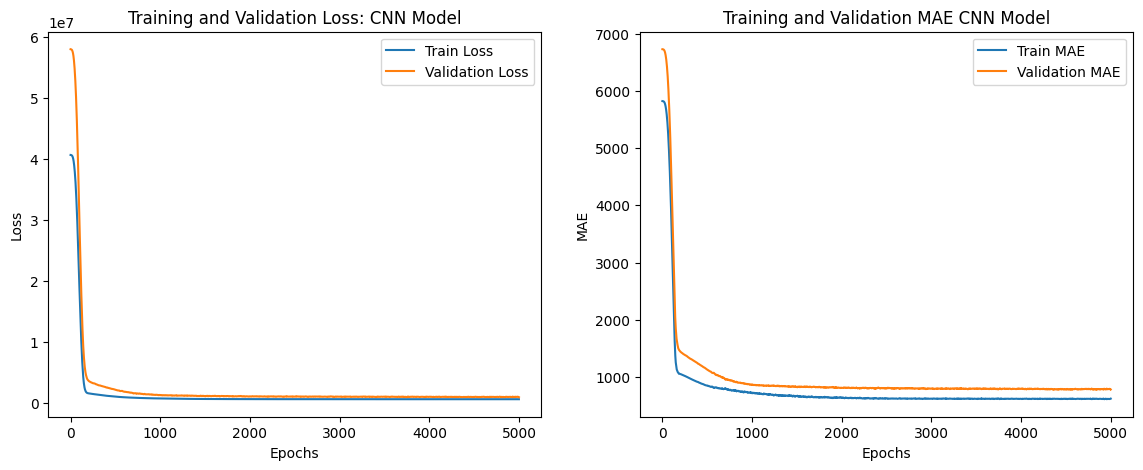

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss: CNN Model')


plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['mae'], label='Train MAE')
plt.plot(history_cnn.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE CNN Model')

plt.show()
plt.savefig('results/CNN_training_validation_loss_mae.png')


In [9]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
print(f'Mean Absolute Error: {mae_cnn}')


Mean Absolute Error: 724.6035559895834


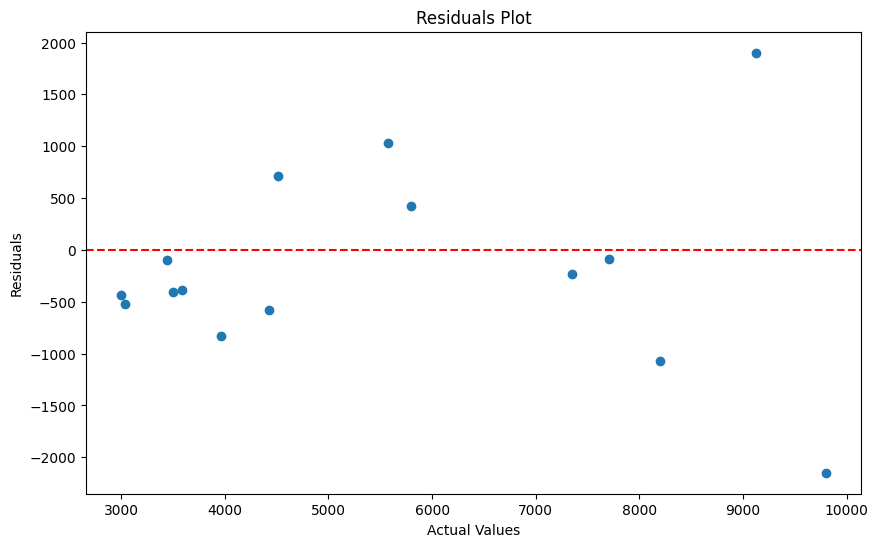

In [10]:
# Plot residuals
residuals_cnn = y_test - y_pred_cnn.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_cnn)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()
